In [1]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import Input, Model
from keras.datasets import mnist
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D
from scipy import ndimage


def normalize_x_data(data):
    return np.reshape(data.astype('float32') / 255, (len(data), 28, 28, 1))


def blur(images, sigma=1, divide_resolution_by=2):
    new_width = images.shape[1] // divide_resolution_by
    new_height = images.shape[2] // divide_resolution_by
    blurred_images = []
    for image in ndimage.gaussian_filter(images, sigma=sigma):
        blurred_images.append(cv2.resize(image, (new_width, new_height)))
    return np.array(blurred_images).reshape(
        (images.shape[0], new_width, new_height) + images.shape[3:]
    )


def load_data():
    (_y_train, _), (_y_test, _) = mnist.load_data()
    print(_y_train.shape)
    print(_y_test.shape)
    _y_train, _y_test = normalize_x_data(_y_train), normalize_x_data(_y_test)
    _x_train, _x_test = blur(_y_train, sigma=0.5), blur(_y_test, sigma=0.5)
    return _x_train, _x_test, _y_train, _y_test


def print_image(image):
    print(image.shape)
    plt.imshow(image[:, :, 0], interpolation='nearest')
    plt.show()


def build_unblurer_model():
    input_layer = Input(shape=(14, 14, 1))
    x = Convolution2D(
        filters=16,
        kernel_size=4,
        border_mode="same"
    )(input_layer)
    # x = MaxPooling2D(pool_size=(2, 2), border_mode="same")(x)
    # x = Convolution2D(
    #     filters=32,
    #     kernel_size=4,
    #     border_mode="same"
    # )(x)
    # x = UpSampling2D(size=(2, 2))(x)
    x = Convolution2D(
        filters=16,
        kernel_size=4,
        border_mode="same"
    )(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Convolution2D(
        filters=1,
        kernel_size=4,
        border_mode="same",
    )(x)
    model = Model(input_layer, x)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    model.summary()
    return model


def build_auto_encoder():
    input_img = Input(shape=(28, 28, 1))
    layer = Convolution2D(
        kernel_size=(4, 4), filters=16, strides=(1, 1), border_mode="same"
    )(input_img)
    layer = MaxPooling2D((2, 2), border_mode="same")(layer)
    layer = Convolution2D(
        kernel_size=(4, 4), filters=32, strides=(1, 1), border_mode="same"
    )(layer)
    layer = MaxPooling2D((2, 2), border_mode="same")(layer)
    layer = Convolution2D(
        kernel_size=(3, 3), filters=16, strides=(1, 1), border_mode="same"
    )(layer)
    layer = UpSampling2D(size=(2, 2))(layer)
    layer = Convolution2D(
        kernel_size=(4, 4), filters=16, strides=(1, 1), border_mode="same"
    )(layer)
    layer = UpSampling2D(size=(2, 2))(layer)
    layer = Convolution2D(
        filters=1, kernel_size=3, strides=1, activation="sigmoid", border_mode="same"
    )(layer)
    model = Model(input_img, layer)
    model.compile(optimizer="adam", loss="binary_crossentropy")
    model.summary()
    return model

Using TensorFlow backend.


In [2]:
x_train, x_test, y_train, y_test = load_data()
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000, 14, 14, 1)
(10000, 14, 14, 1)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


(28, 28, 1)
(14, 14, 1)


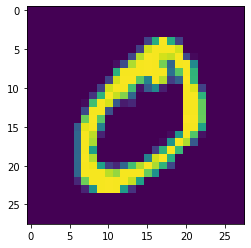

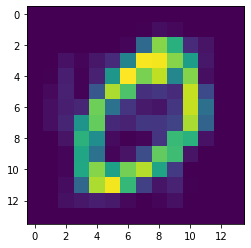

In [3]:
print_image(y_train[1])
print_image(x_train[1])

In [4]:
unblurer = build_unblurer_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        272       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        4112      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 1)         257       
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


/home/louis/anaconda3/envs/DeepLearningCourse/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=16, kernel_size=4, padding="same")`
/home/louis/anaconda3/envs/DeepLearningCourse/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=16, kernel_size=4, padding="same")`
/home/louis/anaconda3/envs/DeepLearningCourse/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=1, kernel_size=4, padding="same")`


In [5]:
unblurer.fit(
    x=x_train,
    y=y_train,
    batch_size=256,
    nb_epoch=2,
    shuffle=True,
    validation_data=(x_test, y_test)
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 41s 679us/step - loss: 0.1209 - val_loss: 0.0908

/home/louis/anaconda3/envs/DeepLearningCourse/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


In [6]:
unblurred_x_test = unblurer.predict(x_test)
unblurred_x_train = unblurer.predict(x_train)

In [7]:
noise_remover = build_auto_encoder()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 16)        272       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 16)        0  

/home/louis/anaconda3/envs/DeepLearningCourse/lib/python3.6/site-packages/ipykernel_launcher.py:75: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(4, 4), filters=16, strides=(1, 1), padding="same")`
/home/louis/anaconda3/envs/DeepLearningCourse/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), padding="same")`
/home/louis/anaconda3/envs/DeepLearningCourse/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(4, 4), filters=32, strides=(1, 1), padding="same")`
/home/louis/anaconda3/envs/DeepLearningCourse/lib/python3.6/site-packages/ipykernel_launcher.py:81: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), padding="same")`
/home/louis/anaconda3/envs/DeepLearningCourse/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: Update your `Co

In [8]:
noise_remover.fit(
    x=unblurred_x_train,
    y=y_train,
    batch_size=256,
    nb_epoch=2,
    shuffle=True,
    validation_data=(unblurred_x_test, y_test)
)

/home/louis/anaconda3/envs/DeepLearningCourse/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 48s 802us/step - loss: 0.1476 - val_loss: 0.0980

In [9]:
noise_removed_x_test = noise_remover.predict(unblurred_x_test)
noise_removed_x_train = noise_remover.predict(unblurred_x_train)

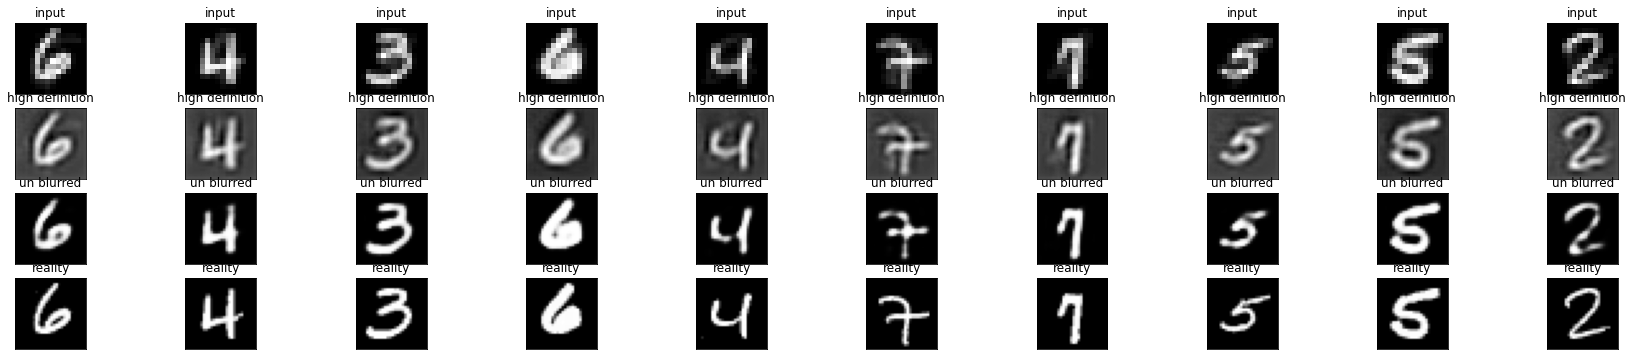

In [21]:
row_nbr = 4
n = 10
plt.figure(figsize=(30,6))
random.seed(10)
for i in range(n):
    img_index = random.randint(0, len(x_test) - 1)

    ax = plt.subplot(row_nbr, n, i+1+n*0)
    plt.imshow(x_test[img_index].reshape(14,14))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('input')

    ax = plt.subplot(row_nbr, n, i+1+n*1)
    plt.imshow(unblurred_x_test[img_index].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('high definition')

    ax = plt.subplot(row_nbr, n, i+1+n*2)
    plt.imshow(noise_removed_x_test[img_index].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('un blurred')

    ax = plt.subplot(row_nbr, n, i+1+n*3)
    plt.imshow(y_test[img_index].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('reality')

plt.show()